In [1]:
import tensorflow as tf
from tensorflow.keras import datasets

2023-03-06 17:35:03.195104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
from numpy.linalg import inv,solve
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [4]:
nlimg = 32
imgs = np.zeros((len(x_train),nlimg,nlimg))
for imidx in range(len(x_train)):
    imgs[imidx,:,:] = 0.299*np.reshape(x_train[imidx,:,:,0],(nlimg,nlimg))+\
                      0.587*np.reshape(x_train[imidx,:,:,1],(nlimg,nlimg))+\
                      0.114*np.reshape(x_train[imidx,:,:,2],(nlimg,nlimg))

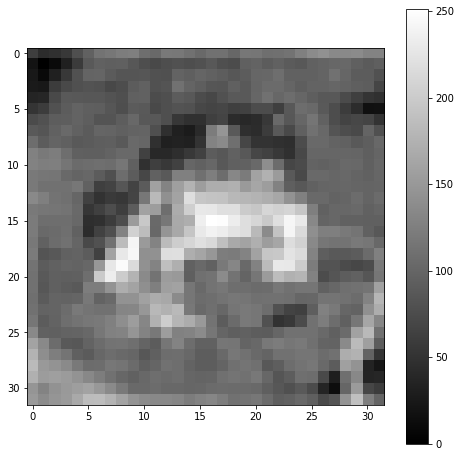

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(imgs[0],cmap='gray')
plt.colorbar()

In [6]:
@tf.function
def gabor(N,theta, x_offset, y_offset, scale):
    theta = tf.clip_by_value(theta,-np.pi,np.pi)
    x_offset = tf.clip_by_value(x_offset,-16,16)
    y_offset = tf.clip_by_value(y_offset,-16,16)
    scale = tf.clip_by_value(scale,0.2,1)

    k = 0.5/scale
    sigma = 5*scale
    gamma = 1

    [x, y] = tf.meshgrid(range(-N,N),range(-N,N))
    x = tf.cast(x,tf.float32) - x_offset
    y = tf.cast(y,tf.float32) - y_offset
    x1 = x * tf.cos(theta) + y * tf.sin(theta)
    y1 = -x * tf.sin(theta) + y * tf.cos(theta)
    gauss = tf.exp(-(gamma**2 * x1**2 + y1**2) / (2 * sigma**2))
    sinusoid = tf.cos(k * x1)

    return (gauss*sinusoid)

In [38]:
thetas = np.linspace(-np.pi,np.pi,15,endpoint=False,dtype=np.float32)
x_offsets = np.linspace(-16,16,5,dtype=np.float32)
y_offsets = np.linspace(-16,16,5,dtype=np.float32)
scales = np.linspace(0.2,1.0,5,dtype=np.float32)

In [39]:
A = np.zeros((nlimg**2,len(thetas)*len(x_offsets)*len(y_offsets)*len(scales)))

iter = np.nditer(np.zeros((len(thetas),len(x_offsets),len(y_offsets),len(scales))),
                      flags=['c_index','multi_index'])

for _ in iter:
    multidx = iter.multi_index
    idx = iter.index
    A[:,idx] = (gabor(nlimg//2,thetas[multidx[0]],x_offsets[multidx[1]],
                     y_offsets[multidx[2]],scales[multidx[3]])).numpy().flatten()
    
ATA = A.T@A

print(A.shape)

(1024, 1875)


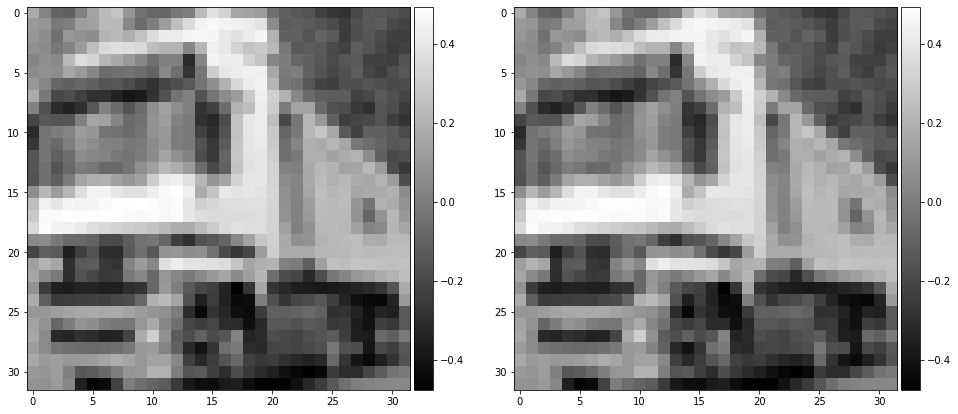

In [40]:
imgidx = 1

def imshowbar(ax,A,cmap):
    imsh = ax.imshow(A,cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

fig, axs = plt.subplots(1,2,figsize=(16,8))

imshowbar(axs[0],(imgs[imgidx]/255 - 0.5),cmap='gray')

y = solve(ATA,A.T@(imgs[imgidx]/255 - 0.5).flatten())

imshowbar(axs[1],(A@y).reshape(nlimg,nlimg),cmap='gray')

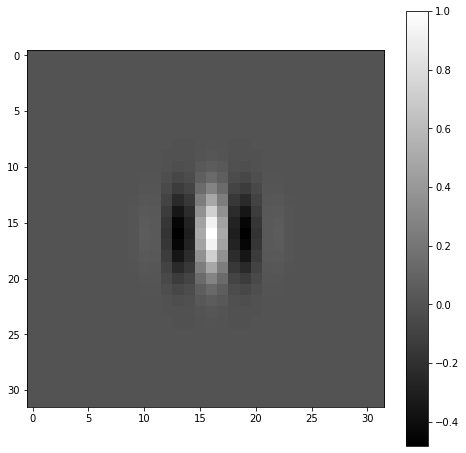

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(gabor(nlimg//2,0.0,0.0,0.0,0.5),cmap='gray')
plt.colorbar()

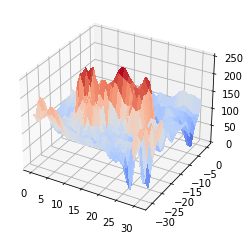

In [78]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(np.arange(nlimg),np.arange(nlimg))
ax.plot_surface(X,-Y,imgs[0].T,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [43]:
10**(0.1*(np.arange(5) - 4))

array([0.39810717, 0.50118723, 0.63095734, 0.79432823, 1.        ])